In [1]:
#author: Mohamed Badreldin  
!pip install plotly
!pip install folium
!conda install -c conda-forge fbprophet
!pip install SQLAlchemy

     |████████████████████████████████| 92kB 8.3MB/s eta 0:00:011
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_linux-64-2.34     |      hc952b39_18          21 KB  conda-forge
    binutils_impl_linux-64-2.34|       h53a641e_0         9.2 MB  conda-forge
    pystan-2.17.1.0            |py36hf2d7682_1004        14.0 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    gcc_linux-64-7.3.0         |      h553295d_18          22 KB  conda-forge
    ephem-3.7.7.1              |   py36h516909a_0         722 KB  conda-forge
    fbprophet-0.6              |   py36he1b5a44_0         642 KB  conda-forge
    lunarcalendar-0.0.9  

In [2]:
# importing the required libraries
from fbprophet import Prophet
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import folium 
from folium import plugins

Importing plotly failed. Interactive plots will not work.


In [3]:
#GET UPDATED DATA FROM JOHN HOPKINS
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_death = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_recovered = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")



In [4]:
#SOME PREPROCESSING AND DATA MANIPULATION
def preprocessdf(df_data_1):
    
    df_data_1.rename(columns={'Country/Region':'Country'},inplace=True)
    df_data_1 = df_data_1.melt(id_vars=['Province/State', 'Country', 'Lat','Long'], 
        var_name='Date', 
        value_name='Confirmed')
    return df_data_1


In [5]:
df_confirmed = preprocessdf(df_confirmed)
df_death = preprocessdf(df_death)
df_recovered = preprocessdf(df_recovered)

In [6]:
#SELECT SPECIFIC COUNTRY 
confirmed = df_confirmed.query('Country=="Egypt"').groupby('Date').sum()['Confirmed'].reset_index()
recovered = df_recovered.query('Country=="Egypt"').groupby('Date').sum()['Confirmed'].reset_index()
death = df_death.query('Country=="Egypt"').groupby('Date').sum()['Confirmed'].reset_index()
confirmed.head()
confirmed.tail()

,Date,Confirmed
92,4/5/20,1173
93,4/6/20,1322
94,4/7/20,1450
95,4/8/20,1560
96,4/9/20,1699


In [31]:
def Forecast_Infection(dta,time,m):
    dta.columns = ['ds','y']
    dta['ds'] = pd.to_datetime(dta['ds'])
    
    m.fit(dta)
    future = m.make_future_dataframe(periods=time)
    #future.tail()
    forecast = m.predict(future)
    #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    return m,forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Confirmed Trend


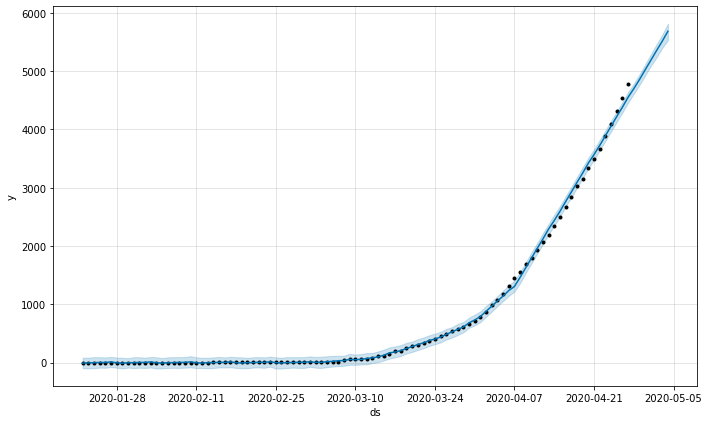

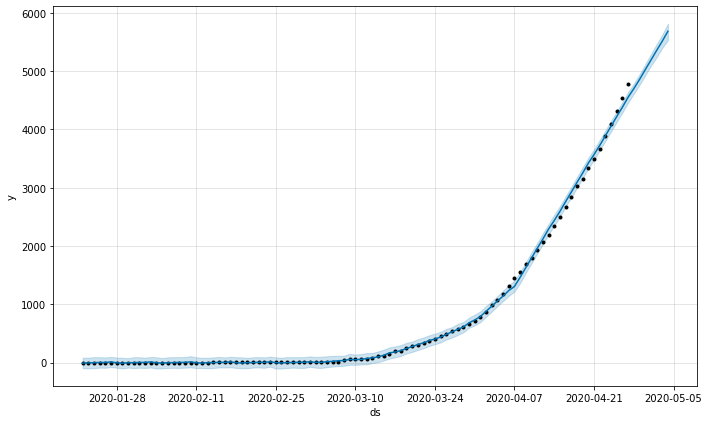

In [34]:
#predicting the future with date, and upper and lower limit of y value
m = Prophet(interval_width=0.95)
print("Confirmed Trend")
m,forecast_confirmed = Forecast_Infection(confirmed,7,m)
m.plot(forecast_confirmed)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Death Trend


/opt/conda/envs/Python36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



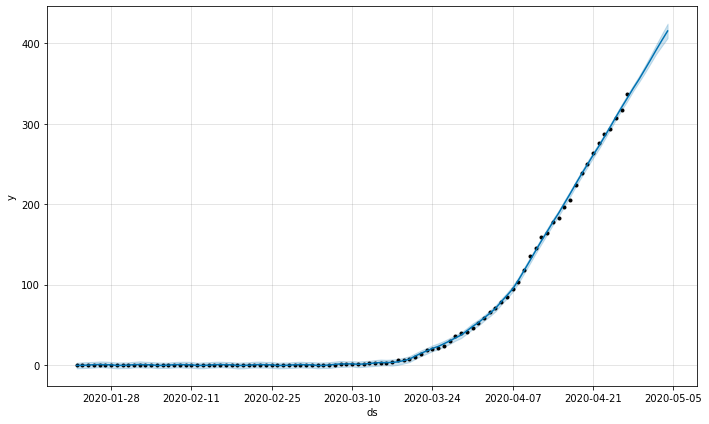

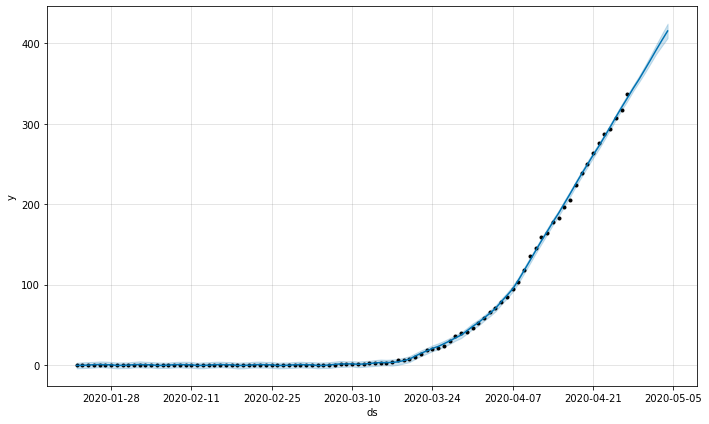

In [29]:
print("Death Trend")
m = Prophet(interval_width=0.95)
m,forecast_death = Forecast_Infection(death,7,m)
m.plot(forecast_death)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Recovery Trend


/opt/conda/envs/Python36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



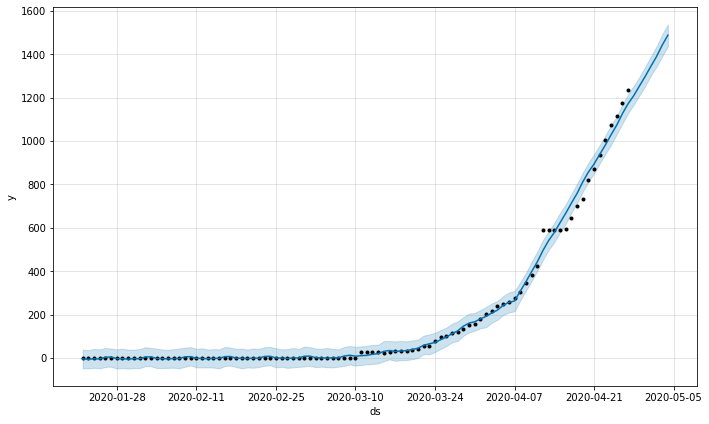

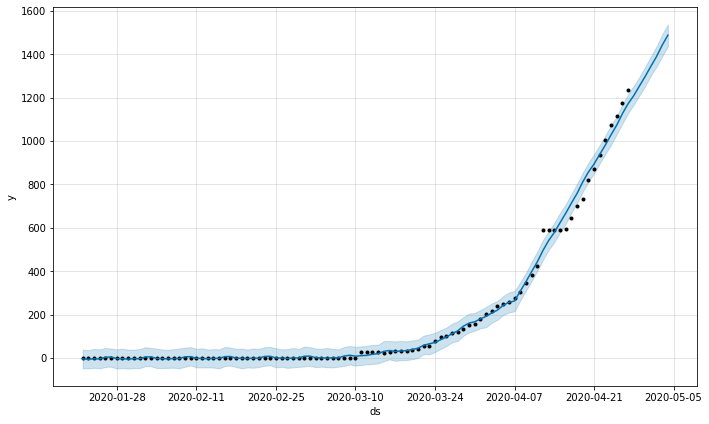

In [30]:
print("Recovery Trend")
m = Prophet(interval_width=0.95)
m,forecast_recovered = Forecast_Infection(recovered,7,m)
m.plot(forecast_recovered)

In [18]:
#ADD DATA 
from sqlalchemy import create_engine
engine = create_engine('postgresql://user:pass@IP:5432/coviddb')
forecast_confirmed.to_sql('Egypt-Forecast', engine,if_exists='replace')
